In [1]:
import numpy as np
import random
import math
import copy
from YenAlgorithm import YenAlgorithm
import time

class Ant(object):
    def __init__(self):
        self.path = []
        self.fitness = float('inf')
        self.delta = 0


class ACS:

    def __init__(self, src, dst, N, Max, K_paths, p, a, b, p0, Q):
        self.switches = [i for i in range(1,21)]
        self.src= src
        self.dst = dst
        self.weight_map= self.GetWeightMap()
        self.adjacency = copy.deepcopy(self.weight_map)
        self.N = N
        self.Max = Max
        self.K_paths = K_paths
        self.p = p
        self.a = a
        self.b = b
        self.p0 = p0
        self.Q = Q
        self.colony = [Ant() for i in range(self.N)]
        self.condidates = []
        self.best = []
        self.Lnn = self.FindLnn()
        self.t0 = 1/(len(self.switches)*self.Lnn)
        self.pheromone = self.CreatePheromone()
    
    def FindLnn(self):
        path = []
        current_switch = self.src
        path.append(current_switch)
        while(current_switch!=self.dst):
            neighbor_switches = set(self.adjacency[current_switch].keys())-set(path)
            neighbor_switches = list(neighbor_switches)
            if(len(neighbor_switches)==0):
                path.clear()
                current_switch = self.src
                path.append(current_switch)
            else:
                current_switch = self.GetNextSwitchLnn(neighbor_switches, current_switch)
                path.append(current_switch)
        Lnn = self.Evaluate(path)
        return Lnn
                
    def GetNextSwitchLnn(self, neighbor_switches, current_switch):
        next_switch = neighbor_switches[0]
        for sw in neighbor_switches:
            if(self.weight_map[current_switch][sw]<=self.weight_map[current_switch][next_switch]):
                next_switch = sw
        return next_switch
    
    def CreatePheromone(self):
        pheromone = copy.deepcopy(self.adjacency)
        for sw_1 in self.adjacency.keys():
            for sw_2 in self.adjacency[sw_1].keys():
                pheromone[sw_1][sw_2] = self.t0
        return pheromone
    
    def GetWeightMap(self):
        weight_map={}
        temp = 0
        with open('metric_data_20_new.txt') as f:
            for line in f:
                strt = line
                strt2 = strt.split(':')
                my_result = list(map(int, strt2[0].split(',')))
                if (temp!=my_result[0]):
                    weight_map[my_result[0]]={}
                weight_map[my_result[0]][my_result[1]] = int(strt2[1])
                temp = my_result[0]
        return weight_map

    def CreatePath(self):
        for i in range(self.N):
            path = []
            current_switch = self.src
            path.append(current_switch)
            while(current_switch!=self.dst):
                neighbor_switches = set(self.adjacency[current_switch].keys())-set(path)
                neighbor_switches = list(neighbor_switches)
                if(len(neighbor_switches)==0):
                    path.clear()
                    current_switch = self.src
                    path.append(current_switch)
                else:
                    current_switch = self.GetNextSwitch(neighbor_switches, current_switch)
                    path.append(current_switch)
            self.colony[i].path = copy.deepcopy(path)
            self.colony[i].fitness = self.Evaluate(self.colony[i].path)
            self.colony[i].delta = self.Q/self.colony[i].fitness

    def GetNextSwitch(self, neighbor_switches, current_switch):
        summ = 0
        for sw in neighbor_switches:
            x = self.pheromone[current_switch][sw]
            y = 1/(self.weight_map[current_switch][sw])
            z = pow(x,self.a)*pow(y,self.b)
            summ+=z
        prob = []
        prob_2 = []
        sw_max = 1
        z_max = 0
        for sw in neighbor_switches:
            x = self.pheromone[current_switch][sw]
            y = 1/(self.weight_map[current_switch][sw])
            z = pow(x,self.a)*pow(y,self.b)
            prob.append(z/summ)
            z2 = x*pow(y,self.b)
            if(z2>z_max):
                z_max = z2
                sw_max = sw
        p = np.random.rand()
        if(p <= self.p0):
            next_switch= sw_max
        else:
            sw = np.random.choice(neighbor_switches,p=prob)
            next_switch= sw
            # update local
            self.pheromone[current_switch][next_switch]=self.pheromone[current_switch][next_switch]*(1-self.p)+self.p*self.t0
            self.pheromone[next_switch][current_switch]=self.pheromone[next_switch][current_switch]*(1-self.p)+self.p*self.t0
        return next_switch

    def Evaluate(self,path):
        calculatedFitness = 0
        for i in range(len(path) - 1):
            p1 = path[i]
            p2 = path[i + 1]
            calculatedFitness += self.weight_map[p1][p2]
        return calculatedFitness
    
    def UpdatePheromone(self):
        # update global
        self.colony.sort(key=lambda x: x.fitness)
        for j in range(len(self.colony[0].path) - 1):
            p1 = self.colony[0].path[j]
            p2 = self.colony[0].path[j + 1]
            self.pheromone[p1][p2] = (1-self.p)*self.pheromone[p1][p2] + self.p*self.colony[0].delta
            self.pheromone[p2][p1] = (1-self.p)*self.pheromone[p2][p1] + self.p*self.colony[0].delta
     
    def MemorizeCondidates(self):
#         self.colony.sort(key=lambda x: x.fitness)
        condidate = []
        k=0
        for i in range(len(self.colony)):
            dk_3 = False
            for ant in condidate:
                if(tuple(ant.path)==tuple(self.colony[i].path)):
                    dk_3 = True
                    break
            if(dk_3!=True):
                condidate.append(copy.deepcopy(self.colony[i]))
                k=k+1
            if(k==self.K_paths):
                break
        self.condidates.extend(copy.deepcopy(condidate))

    def GetBest(self):
        self.condidates.sort(key=lambda x: x.fitness)
        self.best.clear()
        k=0
        for i in range(len(self.condidates)):
            dk_3 = False
            for ant in self.best:
                if(tuple(ant.path)==tuple(self.condidates[i].path)):
                    dk_3 = True
                    break
            if(dk_3!=True):
                self.best.append(copy.deepcopy(self.condidates[i]))
                k=k+1
            if(k==self.K_paths):
                break
        
    def Do(self):
        for i in range(self.Max):
            self.CreatePath()
            self.UpdatePheromone()
            self.MemorizeCondidates()
        self.GetBest()

In [2]:
Times = 20
N = 20
Max = 100
K_paths = 10
p = 0.1
a = 2
b = 1
p0 = 0.6
Q = 1

In [3]:
import numpy as np
import random
import math
import copy
from YenAlgorithm import YenAlgorithm
import time
weight_map={}
temp = 0
with open('metric_data_20_new.txt') as f:
    for line in f:
        strt = line
        strt2 = strt.split(':')
        my_result = list(map(int, strt2[0].split(',')))
        if (temp!=my_result[0]):
            weight_map[my_result[0]]={}
        weight_map[my_result[0]][my_result[1]] = int(strt2[1])
        temp = my_result[0]
vertices = [i for i in range(1,21)]
alg_y = YenAlgorithm(weight_map,vertices,2,7,K_paths)
paths_vertices = alg_y.compute_shortest_paths()

In [4]:
paths_length = []
for path in paths_vertices:
    s = 0
    for i in range(len(path)-1):
        s+= weight_map[path[i]][path[i+1]]
    paths_length.append(s)
print(paths_length)
paths_vertices

[140, 140, 150, 150, 165, 165, 175, 180, 180, 185]


[[2, 11, 6, 14, 7],
 [2, 9, 10, 12, 13, 7],
 [2, 1, 11, 6, 14, 7],
 [2, 1, 3, 4, 8, 7],
 [2, 15, 18, 5, 7],
 [2, 15, 18, 4, 8, 7],
 [2, 1, 3, 6, 14, 7],
 [2, 16, 17, 19, 20, 7],
 [2, 15, 18, 5, 8, 7],
 [2, 11, 6, 12, 13, 7]]

In [5]:
sum(paths_length)

1630

In [6]:
time_1 = []
solan_1 = np.zeros(K_paths)
CD_1 = []
# for i in range(Times):
#     print(i)
#     alg_1 = ACS(2,7,N, Max, K_paths, p, a, b, 0.3, Q)
#     start_1 = time.time()
#     alg_1.Do()
#     end_1 = time.time()
#     time_1.append(end_1 - start_1)
#     for j in range(len(paths_vertices)):
#         for j2 in range(len(alg_1.best)):
#             if(tuple(alg_1.best[j2].path)==tuple(paths_vertices[j])):
#                 solan_1[j]+=1
#                 break
#     s = 0
#     for member in alg_1.best:
#         for i in range(len(member.path)-1):
#             s+= alg_1.weight_map[member.path[i]][member.path[i+1]]
#     CD_1.append(s)

In [7]:
time_2 = []
solan_2 = np.zeros(K_paths)
CD_2 = []
# for i in range(Times):
#     print(i)
#     alg_2 = ACS(2,7,N, Max, K_paths, p, a, b, 0.6, Q)
#     start_2 = time.time()
#     alg_2.Do()
#     end_2 = time.time()
#     time_2.append(end_2 - start_2)
#     for j in range(len(paths_vertices)):
#         for j2 in range(len(alg_2.best)):
#             if(tuple(alg_2.best[j2].path)==tuple(paths_vertices[j])):
#                 solan_2[j]+=1
#                 break
#     s = 0
#     for member in alg_2.best:
#         for i in range(len(member.path)-1):
#             s+= alg_2.weight_map[member.path[i]][member.path[i+1]]
#     CD_2.append(s)

In [8]:
time_3 = []
solan_3 = np.zeros(K_paths)
CD_3 = []
for i in range(Times):
    print(i)
    alg_3 = ACS(2,7,N, Max, K_paths, p, a, b, p0, Q)
    start_3 = time.time()
    alg_3.Do()
    end_3 = time.time()
    time_3.append(end_3 - start_3)
    for j in range(len(paths_vertices)):
        for j2 in range(len(alg_3.best)):
            if(tuple(alg_3.best[j2].path)==tuple(paths_vertices[j])):
                solan_3[j]+=1
                break
    s = 0
    for member in alg_3.best:
        for i in range(len(member.path)-1):
            s+= alg_3.weight_map[member.path[i]][member.path[i+1]]
    CD_3.append(s)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [9]:
# print(solan_1)
# print(solan_2)
print(solan_3)

[16. 20. 20. 20. 15. 18. 12. 18.  6.  6.]


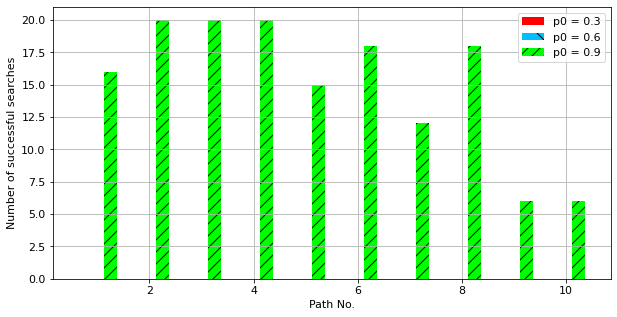

In [10]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
font = {'size'   : 11}
matplotlib.rc('font', **font)
# create data
x = np.arange(K_paths)+1
width = 0.25
  
# plot data in grouped manner of bar type
fig = plt.figure(figsize=(10,5))
# plt.ylim(0,50)
plt.bar(x-0.25, solan_1, width, color='red')
plt.bar(x, solan_2, width, color='deepskyblue', hatch='\\')
plt.bar(x+0.25, solan_3, width, color='lime', hatch='//')
plt.xlabel("Path No.")
plt.ylabel("Number of successful searches")
plt.legend(["p0 = 0.3", "p0 = 0.6", "p0 = 0.9"],loc="upper right")
plt.grid()
plt.savefig("ACS/40.png",dpi=200)

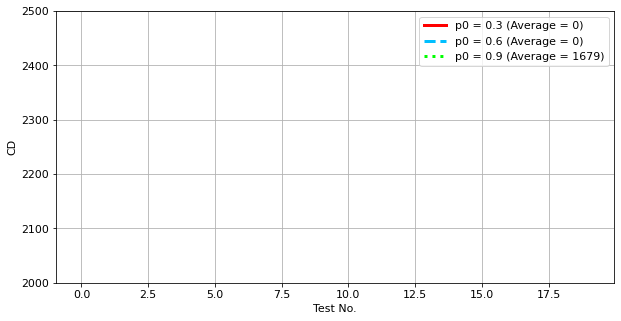

In [11]:
figg1 = plt.figure(figsize=(10,5))
avr_1 = int(sum(CD_1)/Times)
avr_2 = int(sum(CD_2)/Times)
avr_3 = int(sum(CD_3)/Times)
plt.ylim(2000,2500)
plt.plot(CD_1, label = "p0 = 0.3" + " (Average = "+str(avr_1)+")", linewidth = '3', color='red')
plt.plot(CD_2, label = "p0 = 0.6" + " (Average = "+str(avr_2)+")", linewidth = '3', color='deepskyblue', linestyle = 'dashed')
plt.plot(CD_3, label = "p0 = 0.9" + " (Average = "+str(avr_3)+")", linewidth = '3', color='lime', linestyle = 'dotted')
plt.legend(loc="upper right")
plt.xlabel("Test No.")
plt.ylabel("CD")
plt.grid()
plt.savefig("ACS/40_CD.png",dpi=200)

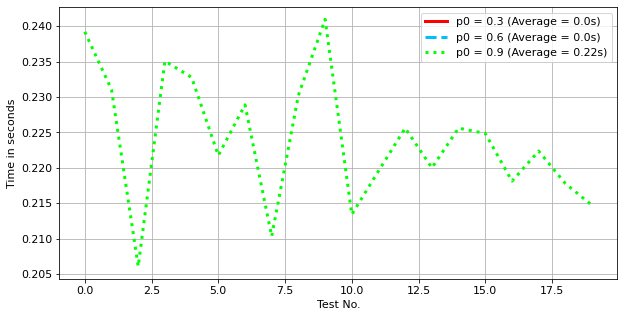

In [12]:
figg2 = plt.figure(figsize=(10,5))
avr_1 = round(sum(time_1)/Times,2)
avr_2 = round(sum(time_2)/Times,2)
avr_3 = round(sum(time_3)/Times,2)
# plt.ylim(0,60)
plt.plot(time_1, label = "p0 = 0.3" + " (Average = "+str(avr_1)+"s)", linewidth = '3', color='red')
plt.plot(time_2, label = "p0 = 0.6" + " (Average = "+str(avr_2)+"s)", linewidth = '3', color='deepskyblue', linestyle = 'dashed')
plt.plot(time_3, label = "p0 = 0.9" + " (Average = "+str(avr_3)+"s)", linewidth = '3', color='lime', linestyle = 'dotted')
plt.legend(loc="upper right")
plt.xlabel("Test No.")
plt.ylabel("Time in seconds")
plt.grid()
plt.savefig("ACS/40_time.png",dpi=200)